In [173]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import time
import seaborn as sns
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tracemalloc
import random
import re
from mlxtend.preprocessing import TransactionEncoder

In [174]:
# matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 支持中文
matplotlib.rcParams['axes.unicode_minus'] = False  # 以正確顯示負號

In [175]:
# Step 1: 資料前置處理
def preprocess_data(file_path):
    data = pd.read_csv(file_path)
    processed_data = data[data['QUANTITY'] > 0]
    return processed_data

In [176]:
# Step 2: 資料轉換
def encode_data(processed_data):
    transactions = processed_data.groupby('INVOICE_NO')['ITEM_NO'].apply(list).values.tolist()
    encoder = TransactionEncoder()
    encoded_data = encoder.fit(transactions).transform(transactions)
    return pd.DataFrame(encoded_data, columns=encoder.columns_)

In [177]:
# 讀取資料
file_path = 'D:\\Test4\\data.csv'
processed_data = preprocess_data(file_path)
df_encoded = encode_data(processed_data)

In [178]:
# Step 3: 使用Apriori演算法
def run_apriori(df_encoded, min_support=0.005, min_confidence=0.5):
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    return rules

In [179]:
# Step 4: 使用FP-Growth演算法
def run_fpgrowth(df_encoded, min_support=0.005, min_confidence=0.5):
    frequent_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    return rules

In [180]:
# Step 5: 儲存和讀取規則
def save_rules(rules, file_name):
    rules.to_csv(file_name, index=False)

def load_rules(file_name):
    return pd.read_csv(file_name)

In [181]:
# 清理資料：移除數量為零或負值的交易記錄
cleaned_data = data[data['QUANTITY'] > 0]

In [183]:
# 轉換數據格式：創建basket格式的資料框，並確保所有值為布爾型
basket = (cleaned_data.groupby(['INVOICE_NO', 'ITEM_ID'])['QUANTITY']
          .sum().unstack().reset_index().fillna(0)
          .set_index('INVOICE_NO'))
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0).astype(bool)

In [184]:
# 使用 Apriori 演算法
tracemalloc.start()  # 追蹤記憶體
start_time = time.time()
apriori_itemsets = apriori(basket_sets, min_support=0.001, use_colnames=True)
apriori_rules = association_rules(apriori_itemsets, metric="confidence", min_threshold=0.5)
apriori_time = time.time() - start_time
apriori_current, apriori_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()  # 停止追蹤記憶體

In [185]:
# 使用 FP-Growth 演算法
tracemalloc.start()  # 追蹤記憶體
start_time = time.time()
fpgrowth_itemsets = fpgrowth(basket_sets, min_support=0.001, use_colnames=True)
fpgrowth_rules = association_rules(fpgrowth_itemsets, metric="confidence", min_threshold=0.5)
fpgrowth_time = time.time() - start_time
fpgrowth_current, fpgrowth_peak = tracemalloc.get_traced_memory()
tracemalloc.stop()  # 停止追蹤記憶體

In [223]:
# Function to safely recommend products based on rules
def recommend_products_safely1(rules, products, max_recommendations=5):
    recommendations = set()
    for product in products:
        # Adjusting to handle special regex characters in product names
        product_rules = rules[rules['antecedents'].astype(str).str.contains(re.escape(product))]
        recommended = product_rules['consequents'].apply(lambda x: x.strip('{}').split(',')).tolist()
        for r in recommended:
            recommendations.update(r)
        if len(recommendations) >= max_recommendations:
            break
    return list(recommendations)[:max_recommendations]

In [219]:
# def recommend_products_safely1(rules, products, max_recommendations=5):
#     recommendations = set()
#     for product in products:
#         product_rules = rules[rules['antecedents'].apply(lambda x: product in x)]
#         for idx, row in product_rules.iterrows():
#             consequents = row['consequents']
#             for item in consequents:
#                 recommendations.add(item)
#             if len(recommendations) >= max_recommendations:
#                 break
#     return list(recommendations)[:max_recommendations]

In [188]:
# Function to flatten the frozenset into a list and then choose a random product
def get_random_product_from_rules(rules):
    # Flatten the frozenset into a list
    all_products = [item for sublist in rules['antecedents'].dropna().apply(list) for item in sublist]
    # Select a random product
    if all_products:
        return random.choice(all_products)
    else:
        return None

In [189]:
# 轉換為MB
apriori_peak_mb = apriori_peak / 1024 / 1024
fpgrowth_peak_mb = fpgrowth_peak / 1024 / 1024

print("apriori_peak_mb:", apriori_peak_mb)
print("fpgrowth_peak_mb:", fpgrowth_peak_mb)

apriori_peak_mb: 2562.682514190674
fpgrowth_peak_mb: 3.5590362548828125


In [190]:
# 輸出規則到 CSV
# apriori_rules.to_csv(r'D:\Test4\apriori_rules.csv', index=False)
# fpgrowth_rules.to_csv(r'D:\Test4\fpgrowth_rules.csv', index=False)

# 讀入已存檔之關聯規則
apriori_rules_loaded = pd.read_csv(r'D:\\Test4\\apriori_rules.csv')
fpgrowth_rules_loaded = pd.read_csv(r'D:\\Test4\\fpgrowth_rules.csv')

In [191]:
max_recommendations = apriori_rules_loaded.shape[1]

In [192]:
def recommend_products_safely(rules, products, max_recommendations=max_recommendations):
    recommendations = set()
    for product in products:
        product_rules = rules[rules['antecedents'].apply(lambda x: product in x)]
        for idx, row in product_rules.iterrows():
            consequents = row['consequents']
            for item in consequents:
                recommendations.add(item)
            if len(recommendations) >= max_recommendations:
                break
    return list(recommendations)[:max_recommendations]

In [193]:
# 測試推薦系統
test_products = [f'ITEM_ID_{i}' for i in range(1, 1001)]
recommended_products = recommend_products_safely(apriori_rules_loaded, test_products)

In [194]:
# 顯示結果
print("Apriori 演算法耗時:", apriori_time)
print("FP-Growth 演算法耗時:", fpgrowth_time)

Apriori 演算法耗時: 2.5274569988250732
FP-Growth 演算法耗時: 17.89682412147522


In [195]:
# Get a random product from the Apriori rules
random_product_apriori = get_random_product_from_rules(apriori_rules_loaded)
random_product_fpgrowth = get_random_product_from_rules(fpgrowth_rules_loaded)


In [196]:
# 分析不同參數設定與推薦產品數量多寡之關係（示例） fpgrowth
min_support_values = [0.001, 0.005, 0.007]
min_confidence_values = [0.3, 0.4, 0.5]

for min_support in min_support_values:
    for min_confidence in min_confidence_values:
        # 使用FP-Growth演算法生成關聯規則
        fpgrowth_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
        if not fpgrowth_itemsets.empty:
            rules = association_rules(fpgrowth_itemsets, metric="confidence", min_threshold=min_confidence)
            # 隨機選擇一個產品進行推薦
            if random_product_fpgrowth:
                recommendations_fpgrowth = recommend_products_safely(fpgrowth_rules_loaded, [random_product_fpgrowth])
                print(f"支持度: {min_support}, 信心度: {min_confidence}, 選擇的產品: {random_product_fpgrowth}, 推薦產品數量: {len(recommendations_fpgrowth)}")
            else:
                print(f"支持度: {min_support}, 信心度: {min_confidence}, 沒有找到適合的產品進行推薦。")
        else:
            print(f"支持度為 {min_support} 時未找到頻繁項集")

支持度: 0.001, 信心度: 0.3, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.001, 信心度: 0.4, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.001, 信心度: 0.5, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.005, 信心度: 0.3, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.005, 信心度: 0.4, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.005, 信心度: 0.5, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.007, 信心度: 0.3, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.007, 信心度: 0.4, 選擇的產品: }, 推薦產品數量: 10
支持度: 0.007, 信心度: 0.5, 選擇的產品: }, 推薦產品數量: 10


In [197]:
# 分析不同參數設定與推薦產品數量多寡之關係（示例） apriori
min_support_values = [0.001, 0.005, 0.007]
min_confidence_values = [0.3, 0.4, 0.5]

for min_support in min_support_values:
    for min_confidence in min_confidence_values:
        # 使用FP-Growth演算法生成關聯規則
        apriori_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
        if not apriori_itemsets.empty:
            rules = association_rules(apriori_itemsets, metric="confidence", min_threshold=min_confidence)
            # 隨機選擇一個產品進行推薦
            if random_product_apriori:
                recommendations_apriori = recommend_products_safely(apriori_rules_loaded, [random_product_apriori])
                print(f"支持度: {min_support}, 信心度: {min_confidence}, 選擇的產品: {random_product_apriori}, 推薦產品數量: {len(recommendations_apriori)}")
            else:
                print(f"支持度: {min_support}, 信心度: {min_confidence}, 沒有找到適合的產品進行推薦。")
        else:
            print(f"支持度為 {min_support} 時未找到頻繁項集")

支持度: 0.001, 信心度: 0.3, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.001, 信心度: 0.4, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.001, 信心度: 0.5, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.005, 信心度: 0.3, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.005, 信心度: 0.4, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.005, 信心度: 0.5, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.007, 信心度: 0.3, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.007, 信心度: 0.4, 選擇的產品: 9, 推薦產品數量: 10
支持度: 0.007, 信心度: 0.5, 選擇的產品: 9, 推薦產品數量: 10


In [224]:
# If a random product is found from Apriori rules, generate recommendations
if random_product_apriori:
    recommendations_apriori = recommend_products_safely1(apriori_rules_loaded, [random_product_apriori])
    print("Selected Product from Apriori Rules:", random_product_apriori)
    print("Recommended Products (Apriori):", recommendations_apriori)
else:
    print("No product found for recommendation from Apriori Rules.")

Selected Product from Apriori Rules: 9
Recommended Products (Apriori): ['frozenset({70509})', 'frozenset({14980086})', 'frozenset({14752201})', 'frozenset({15194056})', 'frozenset({23004})']


In [225]:
# If a random product is found from FP-Growth rules, generate recommendations
if random_product_fpgrowth:
    recommendations_fpgrowth = recommend_products_safely1(fpgrowth_rules_loaded, [random_product_fpgrowth])
    print("Selected Product from FP-Growth Rules:", random_product_fpgrowth)
    print("Recommended Products (FP-Growth):", recommendations_fpgrowth)
else:
    print("No product found for recommendation from FP-Growth Rules.")

Selected Product from FP-Growth Rules: }
Recommended Products (FP-Growth): ['frozenset({70509})', 'frozenset({1697})', 'frozenset({3336149})', 'frozenset({14760944})', 'frozenset({70449})']


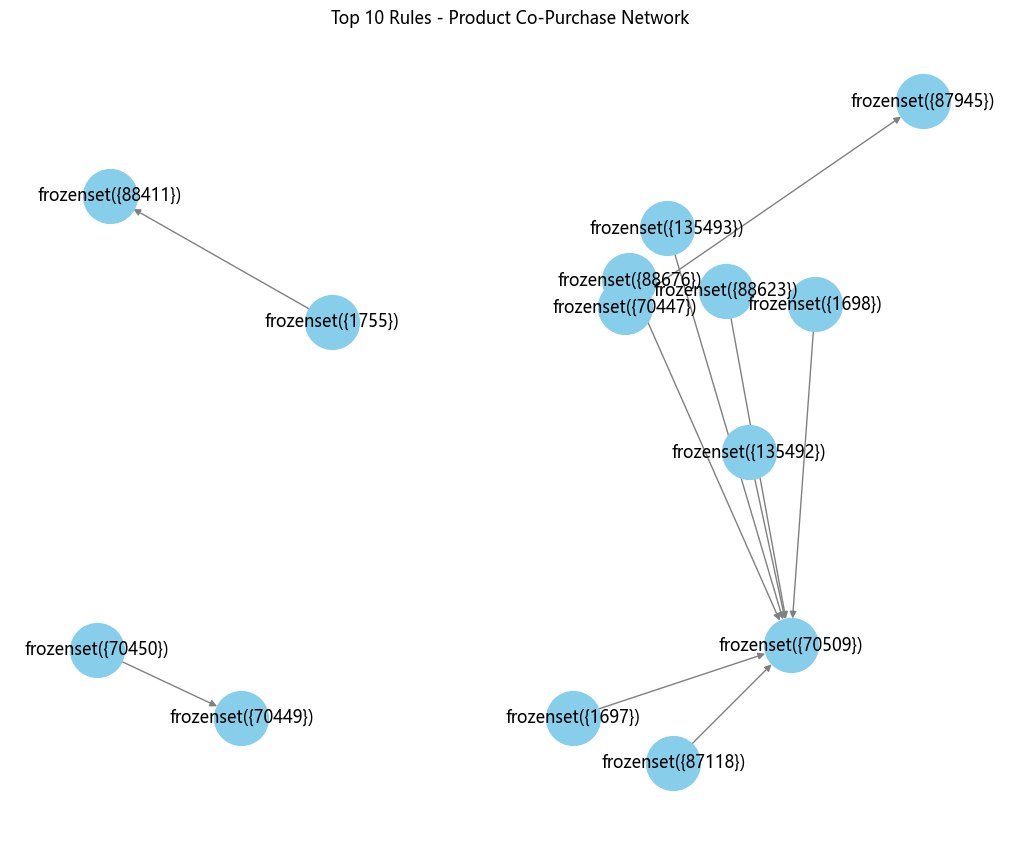

In [226]:
# 1. 產品共購網絡圖
def plot_network_graph(rules, top_n=10):
    G = nx.DiGraph()
    for _, row in rules.head(top_n).iterrows():
        antecedents = tuple(row['antecedents'].strip('{}').split(','))
        consequents = tuple(row['consequents'].strip('{}').split(','))
        G.add_edges_from([(a, c) for a in antecedents for c in consequents])
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray')
    plt.title('Top {} Rules - Product Co-Purchase Network'.format(top_n))
    plt.show()

plot_network_graph(apriori_rules_loaded)

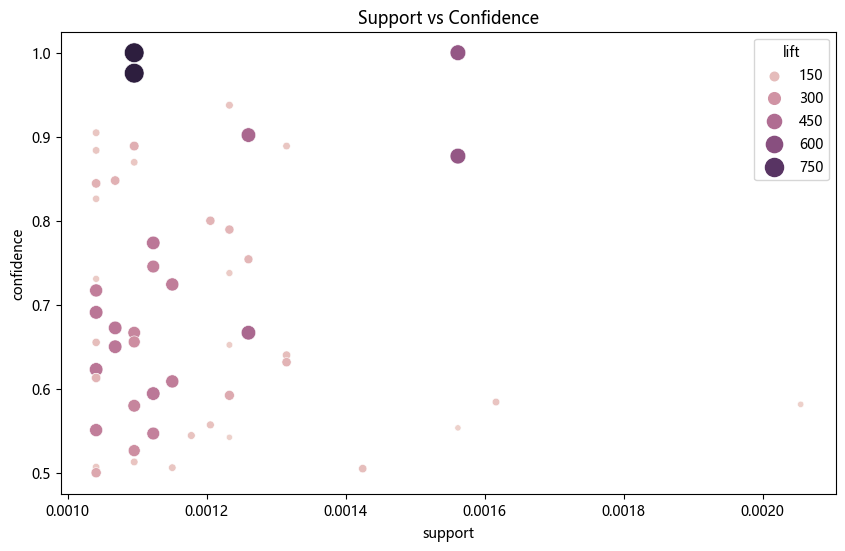

In [227]:
# 2. 支持度和信心度散點圖
def plot_support_confidence(rules):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', sizes=(20, 200))
    plt.title('Support vs Confidence')
    plt.show()

plot_support_confidence(apriori_rules_loaded)

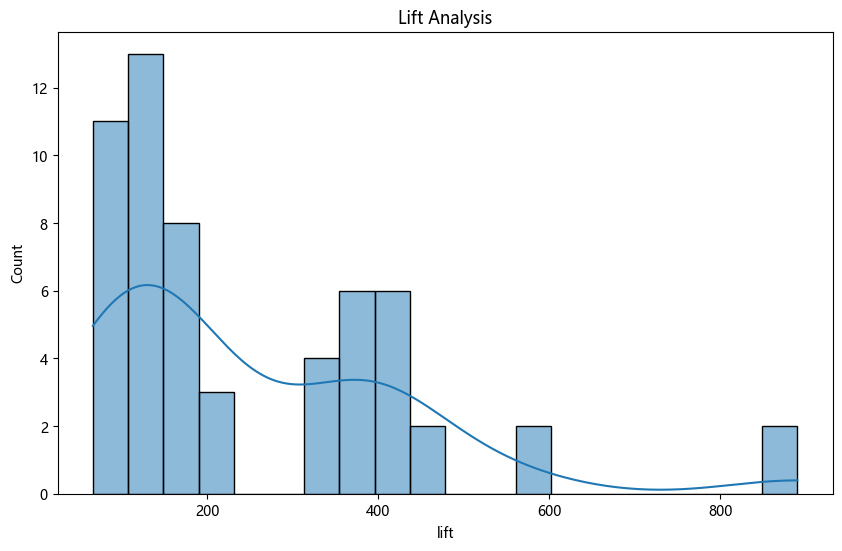

In [228]:
# 3. 提升度（Lift）分析圖
def plot_lift_analysis(rules):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=rules, x='lift', bins=20, kde=True)
    plt.title('Lift Analysis')
    plt.show()

plot_lift_analysis(apriori_rules_loaded)

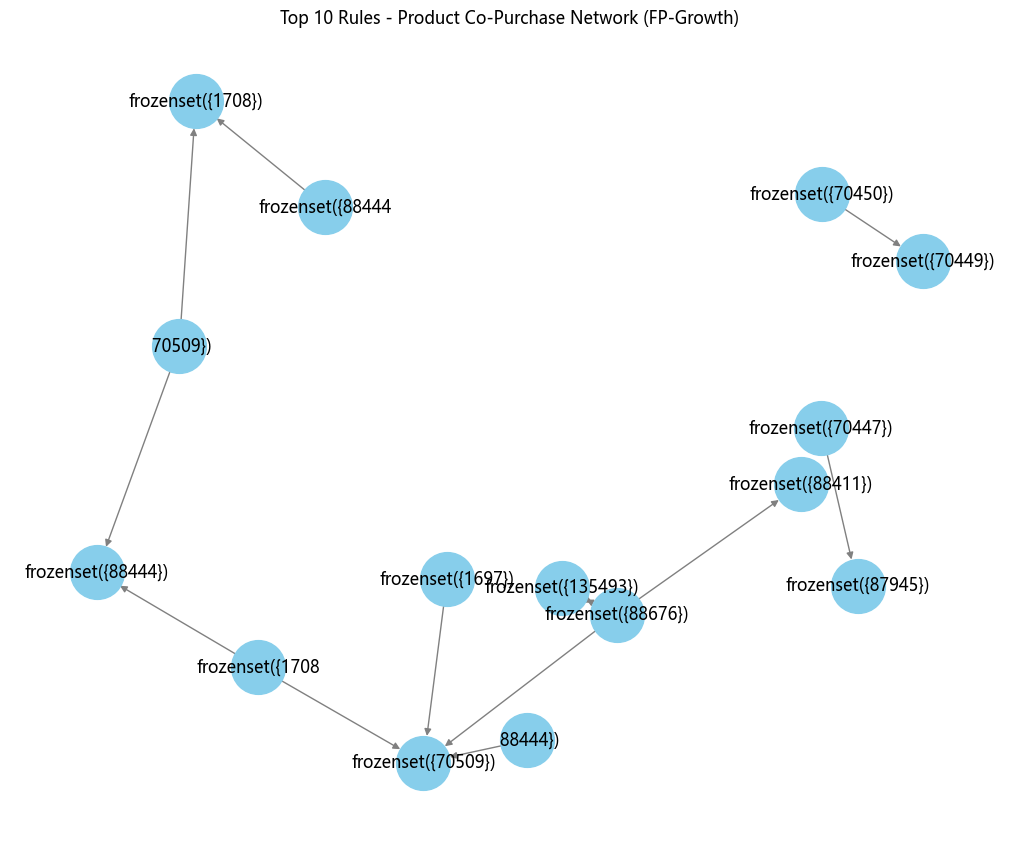

In [229]:
# 1. 產品共購網絡圖
def plot_network_graph(rules, top_n=10):
    G = nx.DiGraph()
    for _, row in rules.head(top_n).iterrows():
        antecedents = tuple(row['antecedents'].strip('{}').split(','))
        consequents = tuple(row['consequents'].strip('{}').split(','))
        G.add_edges_from([(a, c) for a in antecedents for c in consequents])
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray')
    plt.title('Top {} Rules - Product Co-Purchase Network (FP-Growth)'.format(top_n))
    plt.show()
plot_network_graph(fpgrowth_rules_loaded)

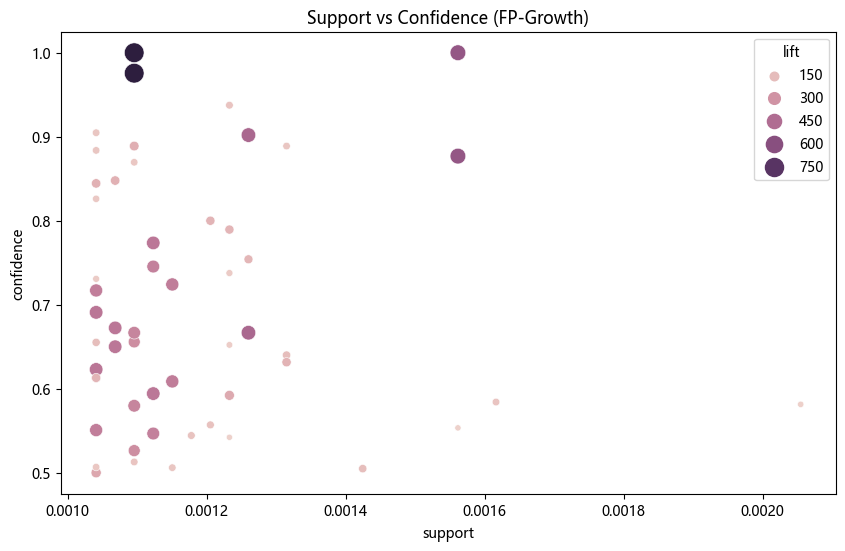

In [230]:
# 2. 支持度和信心度散點圖
def plot_support_confidence(rules):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', sizes=(20, 200))
    plt.title('Support vs Confidence (FP-Growth)')
    plt.show()

plot_support_confidence(fpgrowth_rules_loaded)

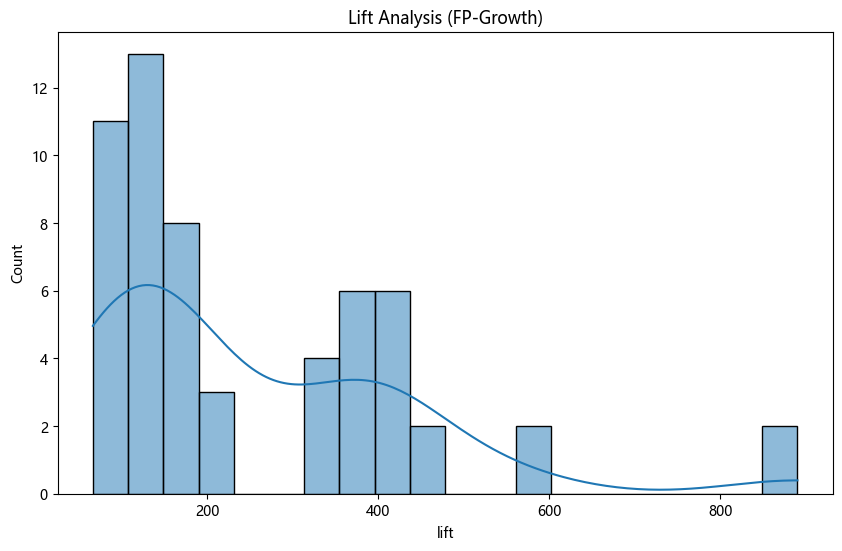

In [205]:
# 3. 提升度（Lift）分析圖
def plot_lift_analysis(rules):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=rules, x='lift', bins=20, kde=True)
    plt.title('Lift Analysis (FP-Growth)')
    plt.show()

plot_lift_analysis(fpgrowth_rules_loaded)

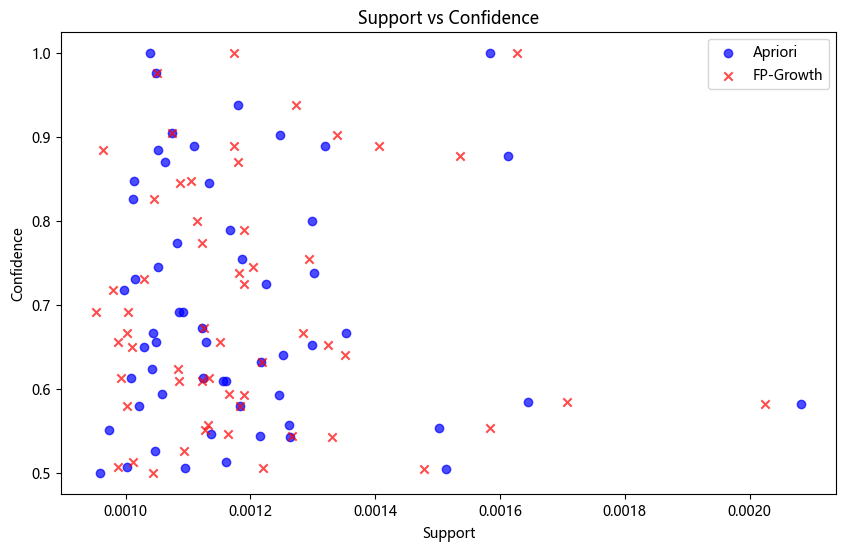

In [231]:
# 1. 支持度-信心度散點圖

jitter = 0.0001

support_jitter_apriori = apriori_rules_loaded['support'] + np.random.uniform(-jitter, jitter, apriori_rules_loaded['support'].shape)
support_jitter_fpgrowth = fpgrowth_rules_loaded['support'] + np.random.uniform(-jitter, jitter, fpgrowth_rules_loaded['support'].shape)

plt.figure(figsize=(10, 6))
plt.scatter(support_jitter_apriori, apriori_rules_loaded['confidence'], alpha=0.7, label='Apriori', marker='o', color='b')
plt.scatter(support_jitter_fpgrowth, fpgrowth_rules_loaded['confidence'], alpha=0.7, label='FP-Growth', marker='x', color='r')
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend()
plt.show()

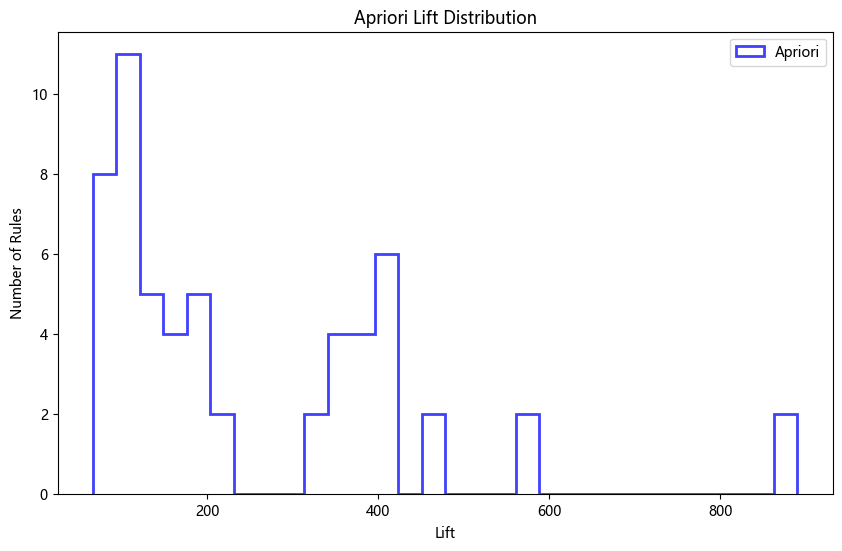

In [232]:
# Apriori提升度分布圖
plt.figure(figsize=(10, 6))
plt.hist(apriori_rules_loaded['lift'], bins=30, color='blue', alpha=0.75, histtype='step', linewidth=2)
plt.title('Apriori Lift Distribution')
plt.xlabel('Lift')
plt.ylabel('Number of Rules')
plt.legend(['Apriori'])
plt.show()

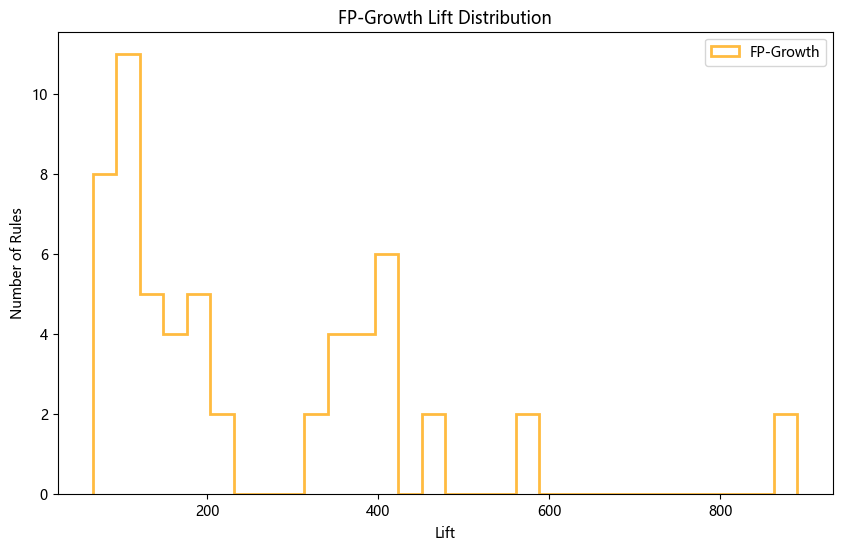

In [233]:
# FP-Growth 提升度分布圖
plt.figure(figsize=(10, 6))
plt.hist(fpgrowth_rules_loaded['lift'], bins=30, color='orange', alpha=0.75, histtype='step', linewidth=2)
plt.title('FP-Growth Lift Distribution')
plt.xlabel('Lift')
plt.ylabel('Number of Rules')
plt.legend(['FP-Growth'])
plt.show()

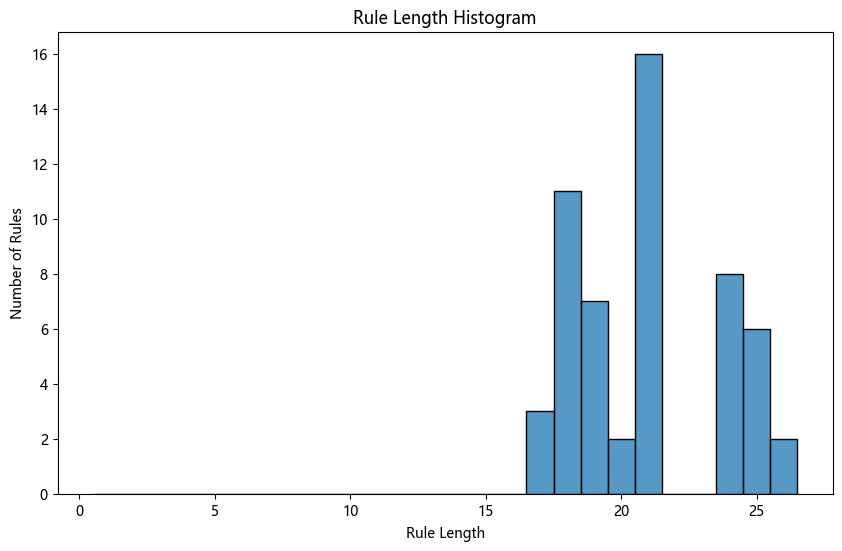

In [234]:
# 3. 規則長度直條圖(APRIORI)
apriori_rules_loaded['rule_length'] = apriori_rules_loaded['antecedents'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.histplot(apriori_rules_loaded['rule_length'], bins=np.arange(1, apriori_rules_loaded['rule_length'].max() + 1) - 0.5, kde=False)
plt.title('Rule Length Histogram')
plt.xlabel('Rule Length')
plt.ylabel('Number of Rules')
plt.show()

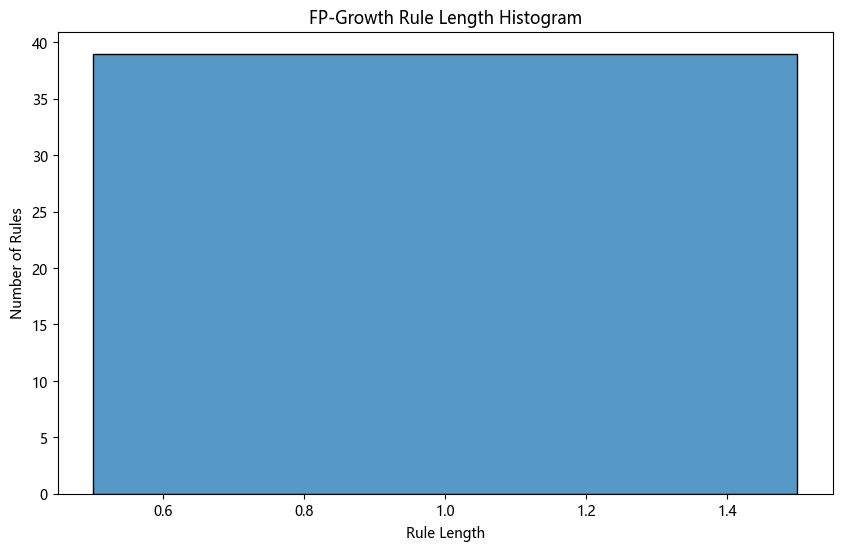

In [235]:
# 繪製直方圖(fpgrowth)

fpgrowth_rules['rule_length'] = fpgrowth_rules['antecedents'].apply(lambda x: len(x))
plt.figure(figsize=(10, 6))
sns.histplot(fpgrowth_rules['rule_length'], bins=np.arange(1, fpgrowth_rules['rule_length'].max() + 1) - 0.5, kde=False)
plt.title('FP-Growth Rule Length Histogram')
plt.xlabel('Rule Length')
plt.ylabel('Number of Rules')
plt.show()

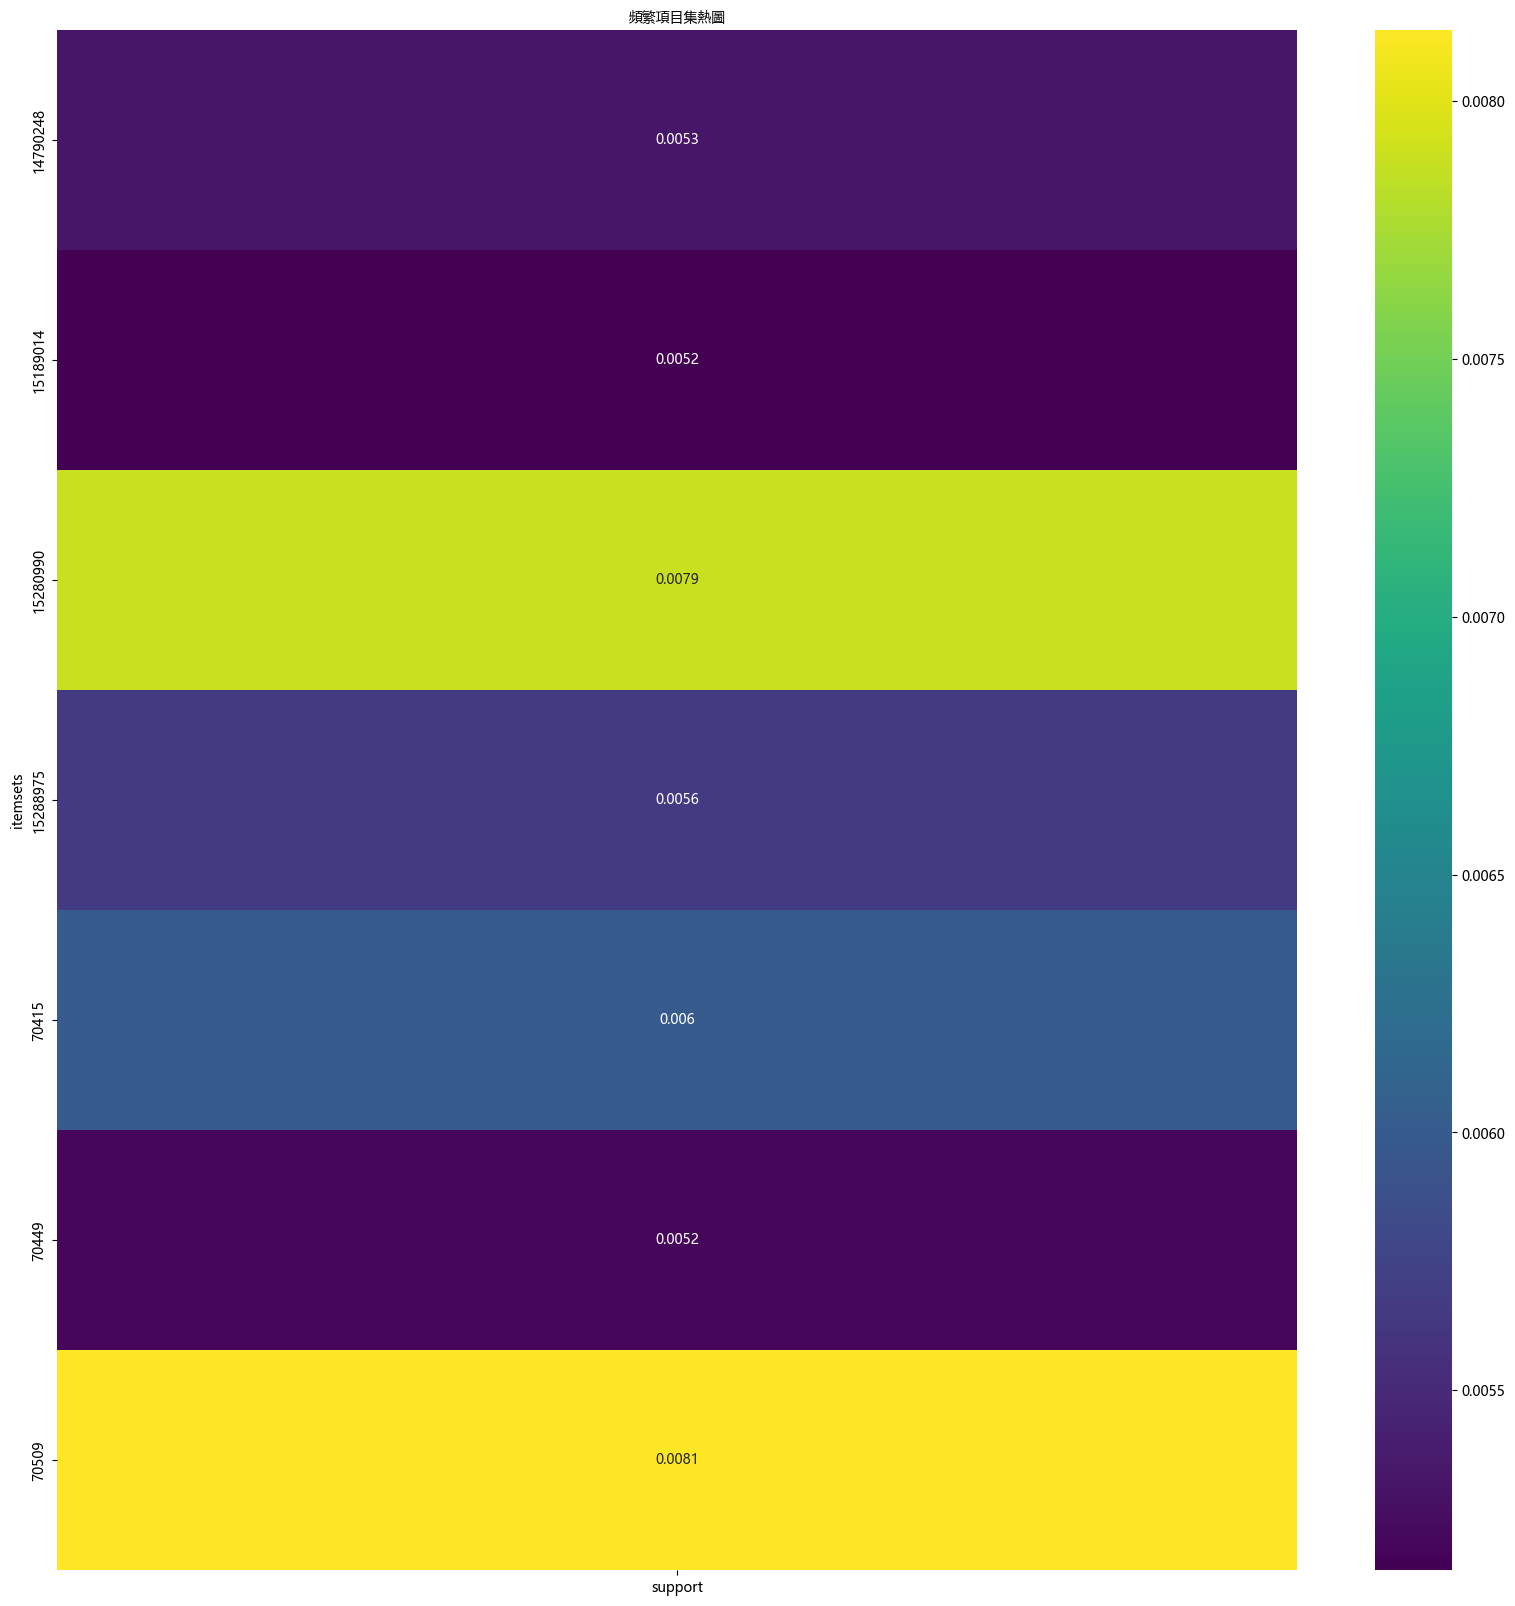

In [236]:
# 4. 頻繁項目集熱圖（以 Apriori 為例）
frequent_itemsets = apriori(basket_sets, min_support=0.005, use_colnames=True)
if not frequent_itemsets.empty:
    frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(str(item) for item in x))
    heatmap_data = frequent_itemsets.pivot_table(index='itemsets', values='support', aggfunc='max').fillna(0)
    
    if heatmap_data.size > 0:
        plt.figure(figsize=(20, 20))
        sns.heatmap(heatmap_data, annot=True, cbar=True, cmap='viridis')
        plt.title('頻繁項目集熱圖', fontproperties='Microsoft YaHei')
        plt.show()
    else:
        print("熱圖數據為空，無法創建熱圖。")
else:
    print("沒有找到足夠的頻繁項目集")

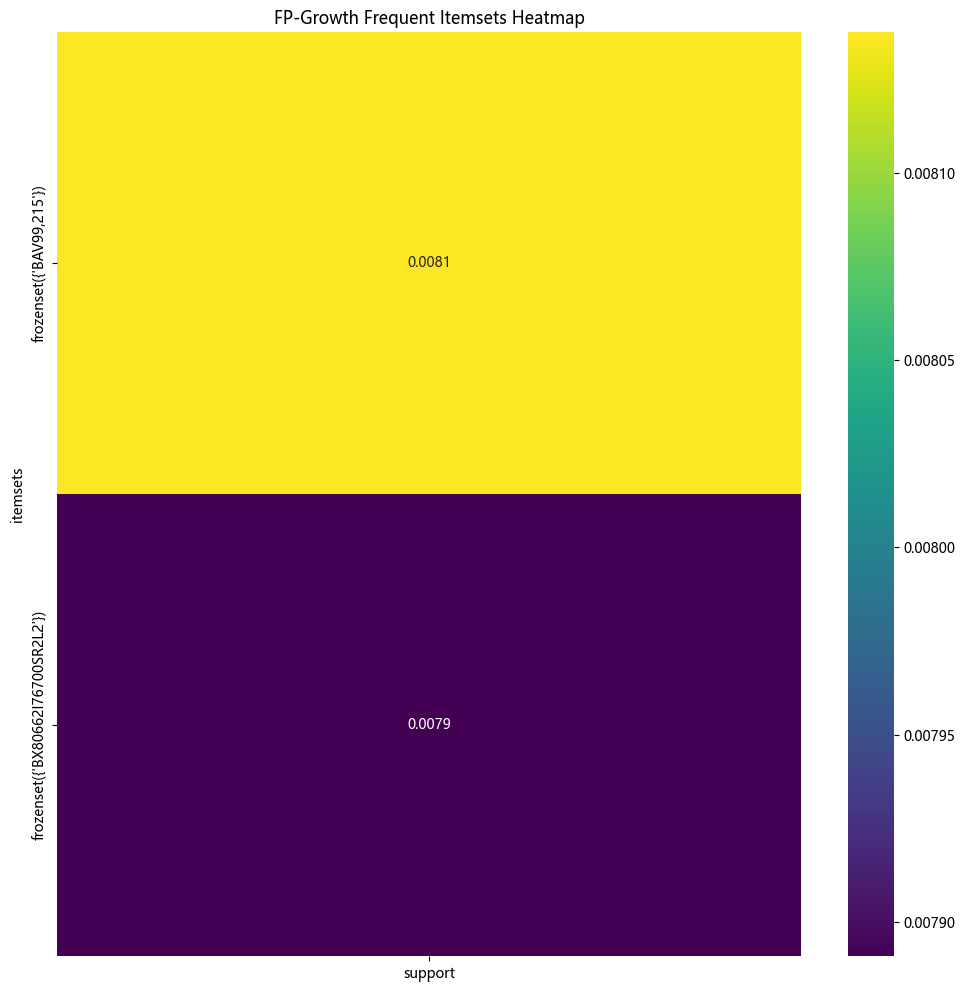

In [237]:
# 4. 頻繁項目集熱圖（以 fpgrowth 為例）
heatmap_data = fpgrowth_itemsets.pivot_table(index='itemsets', values='support', aggfunc='max').fillna(0)
plt.figure(figsize=(12, 12))
sns.heatmap(heatmap_data, annot=True, cbar=True, cmap='viridis')
plt.title('FP-Growth Frequent Itemsets Heatmap')
plt.show()

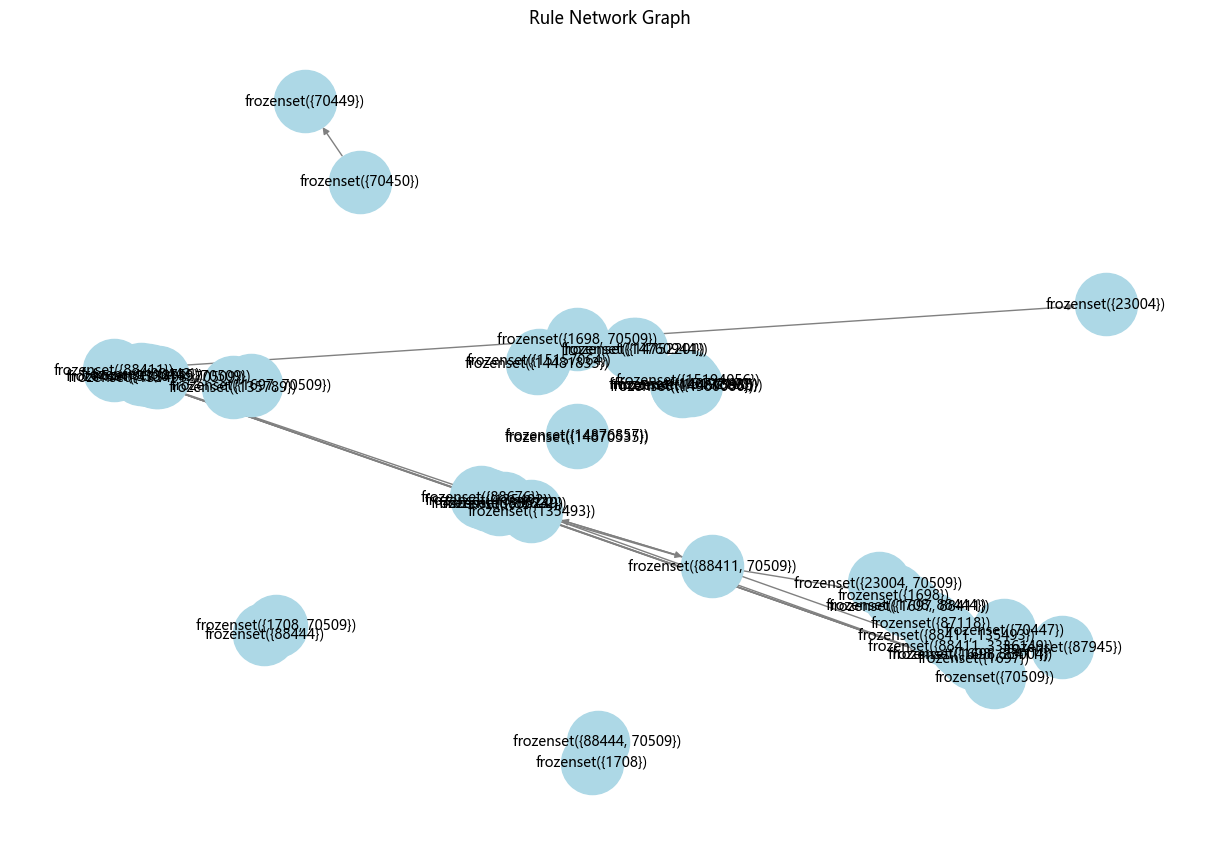

In [238]:
# 5. 規則網路圖（以 Apriori ）
rules = apriori_rules_loaded
G = nx.DiGraph()
for _, row in rules.iterrows():
    G.add_edge(str(row['antecedents']), str(row['consequents']), weight=row['lift'])
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', edge_color='gray', linewidths=1, font_size=10)
plt.title('Rule Network Graph')
plt.show()

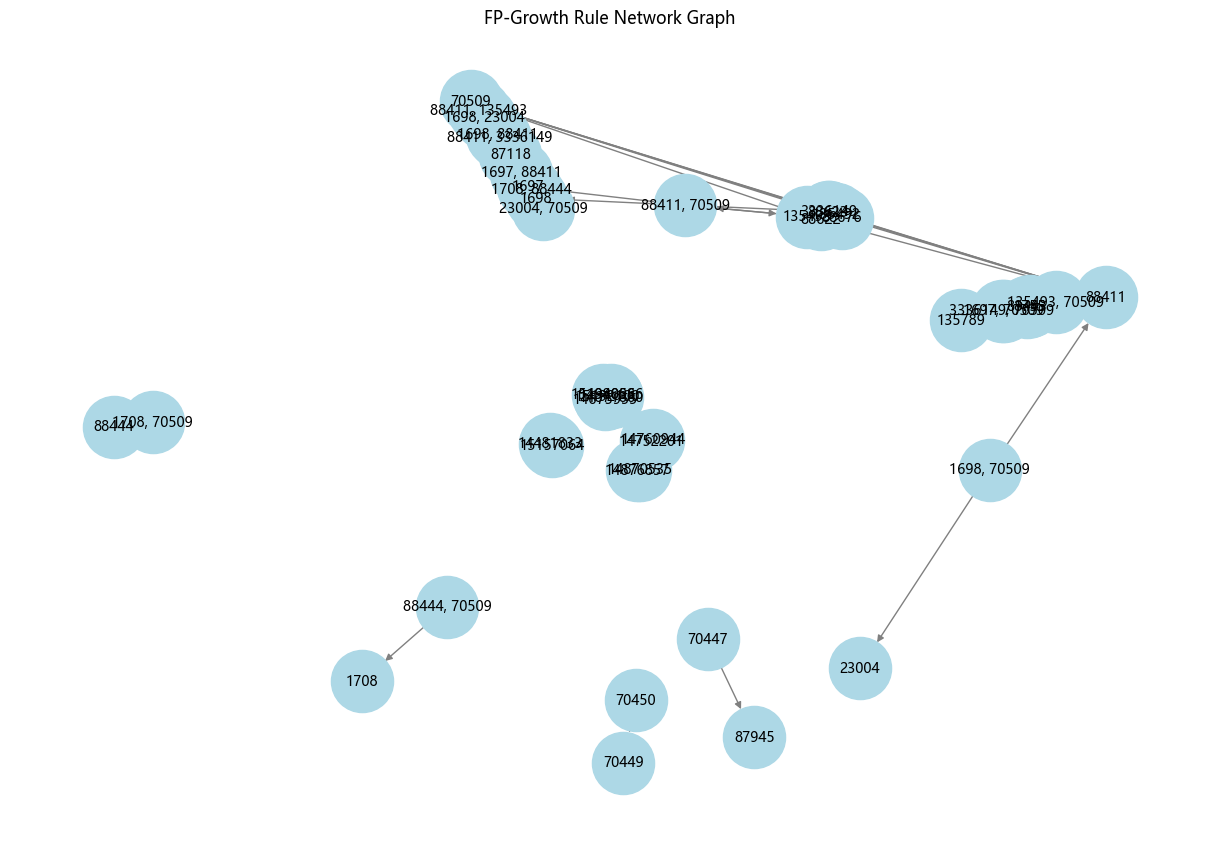

In [239]:
# 5. 規則網路圖（以 fpgrowth ）
G = nx.DiGraph()
for _, row in fpgrowth_rules.iterrows():
    antecedents = ', '.join([str(item) for item in row['antecedents']])
    consequents = ', '.join([str(item) for item in row['consequents']])
    G.add_edge(antecedents, consequents, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', edge_color='gray', linewidths=1, font_size=10)
plt.title('FP-Growth Rule Network Graph')
plt.show()

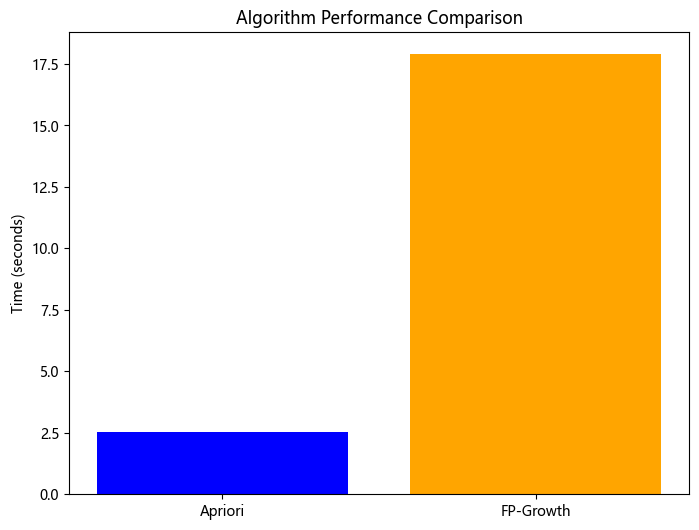

In [240]:
# 6. 性能比較圖
performance = {'Apriori': apriori_time, 'FP-Growth': fpgrowth_time}
plt.figure(figsize=(8, 6))
plt.bar(performance.keys(), performance.values(), color=['blue', 'orange'])
plt.title('Algorithm Performance Comparison')
plt.ylabel('Time (seconds)')
plt.show()

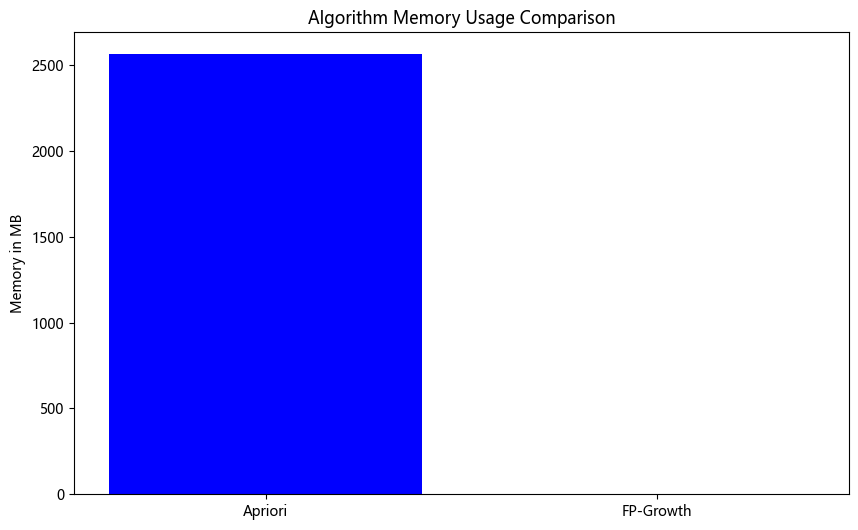

In [241]:
# 記憶體比較圖
plt.figure(figsize=(10, 6))
plt.bar(['Apriori', 'FP-Growth'], [apriori_peak_mb, fpgrowth_peak_mb], color=['blue', 'orange'])
plt.title('Algorithm Memory Usage Comparison')
plt.ylabel('Memory in MB')
plt.show()

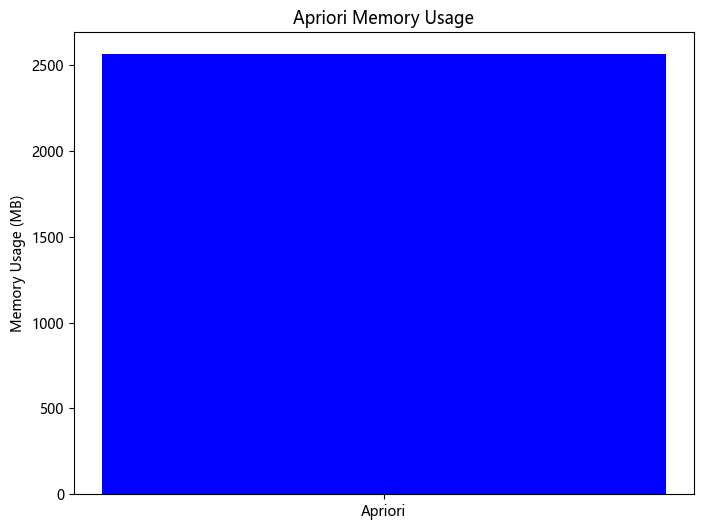

In [242]:
plt.figure(figsize=(8, 6))
plt.bar(['Apriori'], [apriori_peak_mb ], color='blue')
plt.title('Apriori Memory Usage')
plt.ylabel('Memory Usage (MB)')
plt.show()

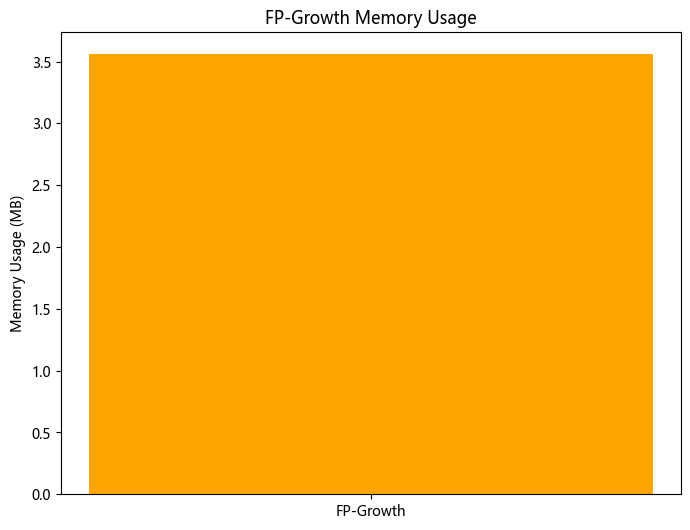

In [243]:
plt.figure(figsize=(8, 6))
plt.bar(['FP-Growth'], [fpgrowth_peak_mb ], color='orange')
plt.title('FP-Growth Memory Usage')
plt.ylabel('Memory Usage (MB)')
plt.show()